# **Homework1 Exploration & Exploitation**  
Napat Aeimwiratchai 65340500020

## Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Bandit class

    a. A constructor which initializes an agent with learnable parameters, and steps for each action.  
    b. A function which returns a reward signal.

In [2]:
class Bandit:
    def __init__(self, n_bandits, rewards, sd):
        self.n_bandits = n_bandits
        self.rewards = rewards
        self.sd = sd
        # self.rewards = np.random.uniform(-1.0,1.0, self.n_bandits)  # True reward distribute (S.D. = 1.0)
    
    def pull(self, action):
        # print(self.rewards[action])
        return np.random.normal(loc=self.rewards[action], scale=self.sd)
    
# rewards = [0.01, 0.0002, 0.1, 0.3, 0.4]
# bandit = Bandit(5, rewards, 1.0)


## Agent class

    a. A constructor which initializes an agent with learnable parameters, and steps for each action.
    b. An update function that updates the agent’s learnable parameters and steps.

In [3]:
class Agent:
    def __init__(self, n_bandits, epsilon=0.1, ucb_c=2):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.ucb_c = ucb_c
        self.q_estimated = np.zeros(n_bandits)  # Estimated reward values
        self.action_counts = np.zeros(n_bandits)  # Action selection counts
        self.total_steps = 0
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_bandits)  # Explore
        else:
            return np.argmax(self.q_estimated)  # Exploit
    
    def select_action_ucb(self):
        self.total_steps += 1
        if 0 in self.action_counts:
            return np.argmin(self.action_counts)  # Ensure each action is selected at least once
        ucb_values = self.q_estimated + self.ucb_c * np.sqrt(np.log(self.total_steps) / (self.action_counts + 1e-5))
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1.0 / self.action_counts[action]  # Incremental update rule
        self.q_estimated[action] += alpha * (reward - self.q_estimated[action])

## Simulation Script

In [4]:
def run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=0.1):
    bandit = Bandit(n_bandits, rewards, sd)
    agent = Agent(n_bandits, epsilon, ucb_c)
    rewards_log = np.zeros((n_bandits, time_steps))
    
    for t in range(time_steps):
        if ucb:
            action = agent.select_action_ucb()
        else:
            action = agent.select_action_epsilon_greedy()
        # print((agent.q_estimated))
        reward = bandit.pull(action)
        agent.update(action, reward)
        rewards_log[action, t] = reward
    
    return rewards_log

In [5]:
def plot_results(n_bandits, rewards, sd, time_steps, epsilon, ucb_c):
    
    rewards_epsilon_greedy = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=ucb_c)
    rewards_ucb = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=True, ucb_c=ucb_c)

    fig, axes = plt.subplots(3, 2, figsize=(16, 14))  

    last_10_percent = int(time_steps * 0.1)  
    time_full = np.arange(time_steps) + 1  

    # --- Full Range Plots ---
    for i in range(n_bandits):
        axes[0, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :]) / time_full, label=f"Bandit {i}")
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_title(f"Epsilon-Greedy Strategy")
    axes[0, 0].set_xlabel("Time Steps (Log Scale)")
    axes[0, 0].set_ylabel("Average Reward")
    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.5)

    for i in range(n_bandits):
        axes[0, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]) / time_full, label=f"Bandit {i}")
    axes[0, 1].set_xscale("log")
    axes[0, 1].set_title(f"Upper Confidence Bound (UCB) Strategy")
    axes[0, 1].set_xlabel("Time Steps (Log Scale)")
    axes[0, 1].set_ylabel("Average Reward")
    axes[0, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.5)

    # --- Zoomed-In (Last 10%) - Match X-Axis with Full Range ---
    for i in range(n_bandits):
        axes[1, 0].plot(time_full[-last_10_percent:], 
                        np.cumsum(rewards_epsilon_greedy[i, -last_10_percent:]) / time_full[-last_10_percent:], 
                        label=f"Bandit {i}")
    axes[1, 0].set_xscale("linear")  # No log scale for zoomed-in view
    axes[1, 0].set_title(f"Epsilon-Greedy Strategy (Last 10% of Timesteps)")
    axes[1, 0].set_xlabel("Time Steps (Actual Scale from Full Range)")
    axes[1, 0].set_ylabel("Average Reward")
    axes[1, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))

    axes[1, 0].grid(True, linestyle="--", linewidth=0.5)

    for i in range(n_bandits):
        axes[1, 1].plot(time_full[-last_10_percent:], 
                        np.cumsum(rewards_ucb[i, -last_10_percent:]) / time_full[-last_10_percent:], 
                        label=f"Bandit {i}")
    axes[1, 1].set_xscale("linear")  # No log scale for zoomed-in view
    axes[1, 1].set_title(f"Upper Confidence Bound (UCB) Strategy (Last 10% of Timesteps)")
    axes[1, 1].set_xlabel("Time Steps (Actual Scale from Full Range)")
    axes[1, 1].set_ylabel("Average Reward")
    axes[1, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))

    axes[1, 1].grid(True, linestyle="--", linewidth=0.5)

    # --- Cumulative Rewards Per Time Step ---
    for i in range(n_bandits):
        axes[2, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :]), alpha=1.0, label=f"Bandit {i}")
    axes[2, 0].set_xscale("log")
    axes[2, 0].set_title("Cumulative Rewards Per Time Step (Epsilon-Greedy)")
    axes[2, 0].set_xlabel("Time Steps (Log Scale)")
    axes[2, 0].set_ylabel("Cumulative Reward")
    axes[2, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[2, 0].grid(True, linestyle="--", linewidth=0.5)

    for i in range(n_bandits):
        axes[2, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]), alpha=0.8, label=f"Bandit {i}")
    axes[2, 1].set_xscale("log")
    axes[2, 1].set_title("Cumulative Rewards Per Time Step (UCB)")
    axes[2, 1].set_xlabel("Time Steps (Log Scale)")
    axes[2, 1].set_ylabel("Cumulative Reward")
    axes[2, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[2, 1].grid(True, linestyle="--", linewidth=0.5)

    plt.suptitle(f"Comparison of Epsilon-Greedy and UCB Algorithms(ε = {epsilon} ,c={ucb_c})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return rewards_epsilon_greedy, rewards_ucb


In [6]:
# Define rewards for the bandits
n_bandits = 5
rewards_each_bandit = [0.1, 0.2, 0.3, 0.4, 0.5]
sd = 0.5
time_step = 100000

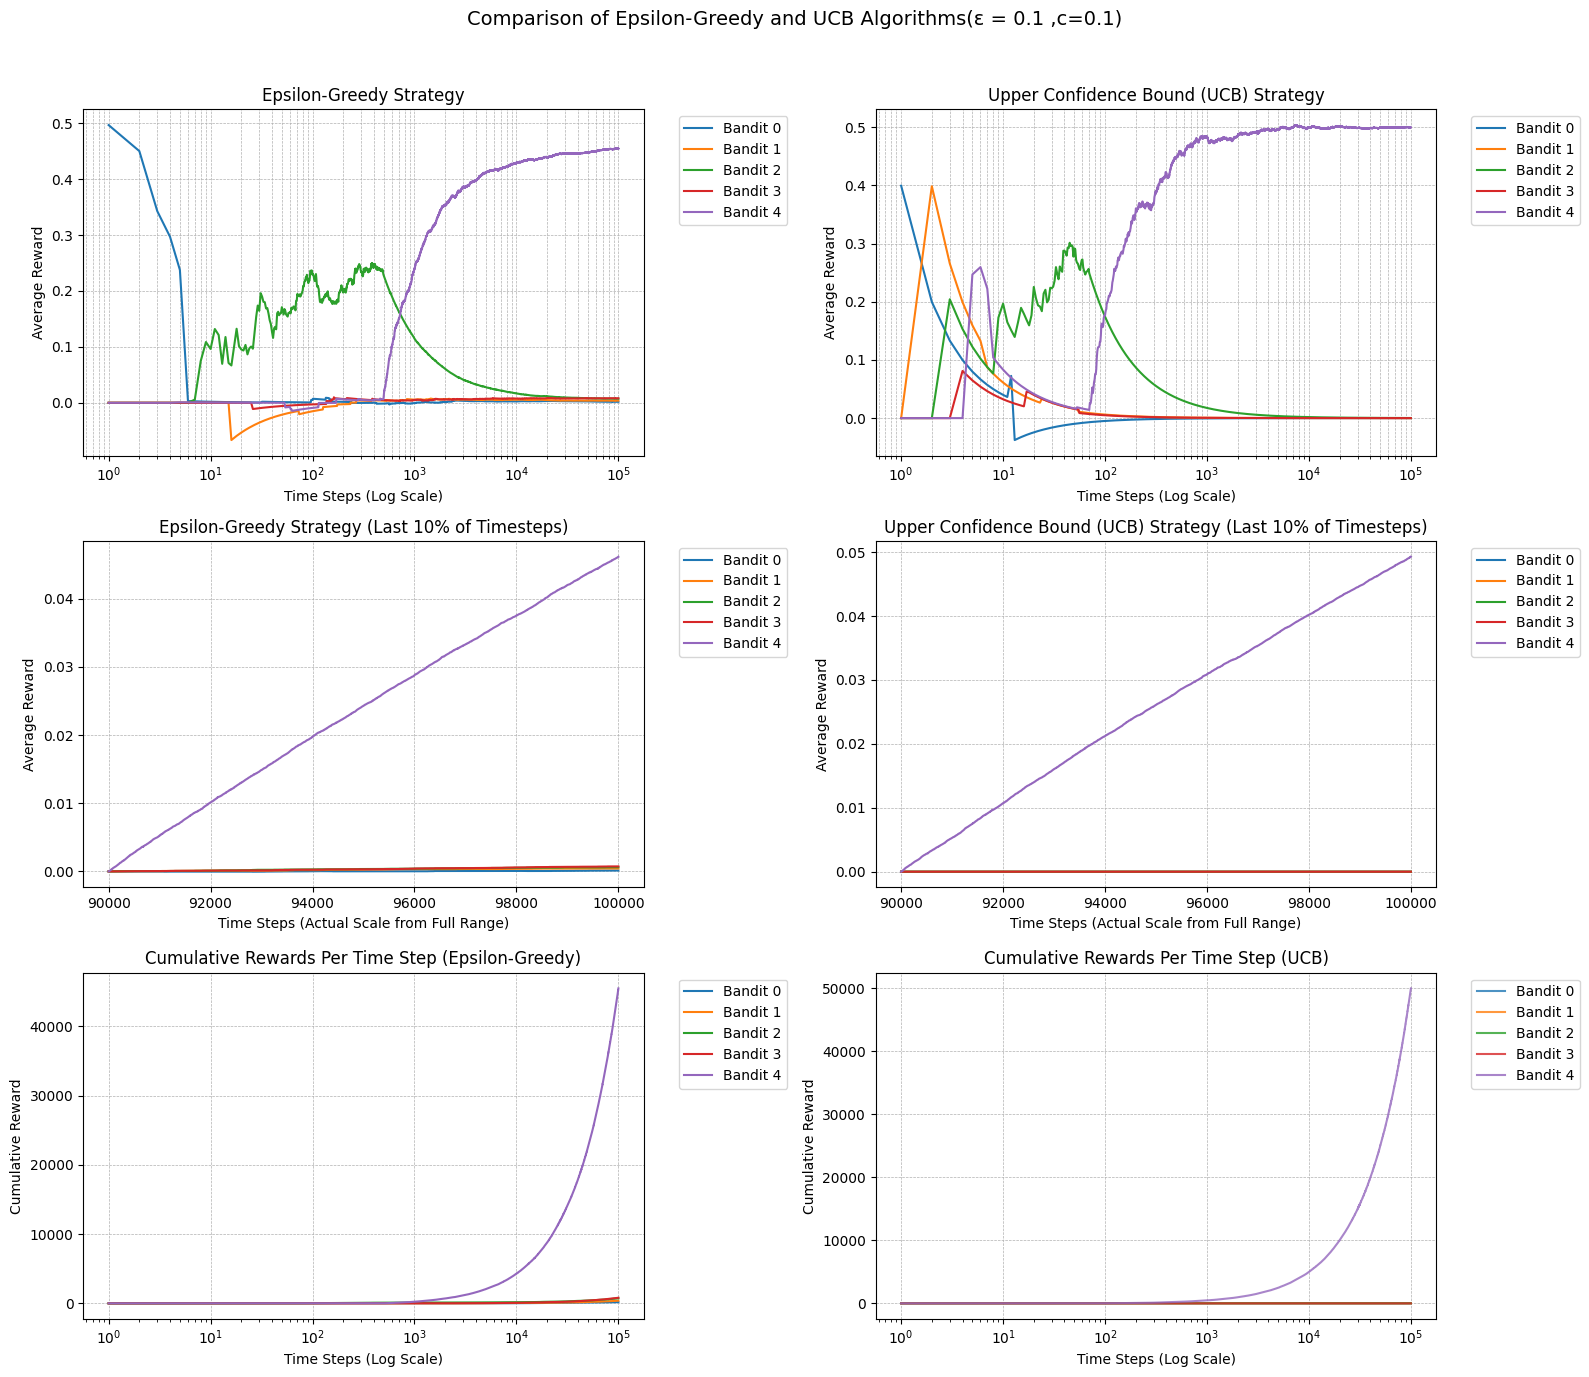

In [7]:
rew_epsilon_1, rew_ucb_1  = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=0.1, ucb_c=0.1)

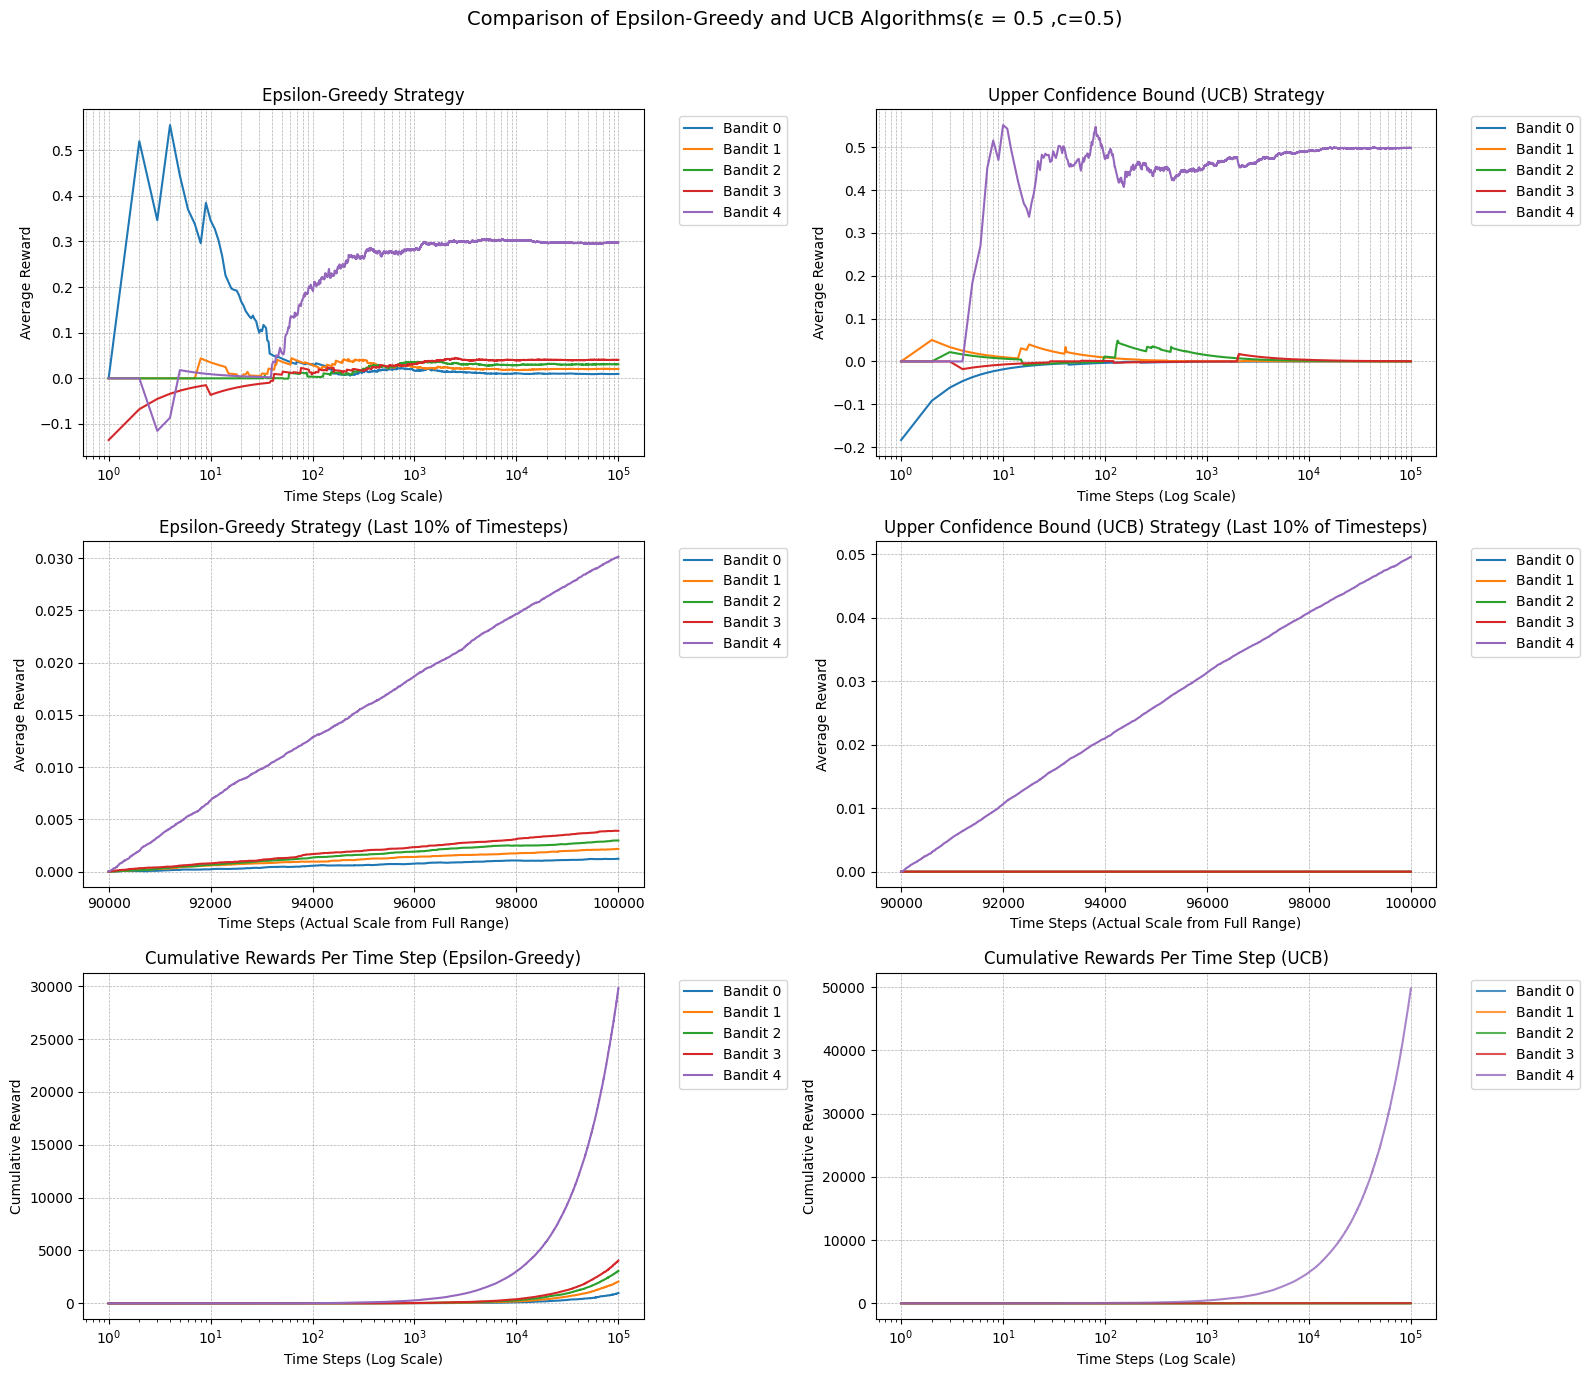

In [8]:
rew_epsilon_2, rew_ucb_2  = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=0.5, ucb_c=0.5)

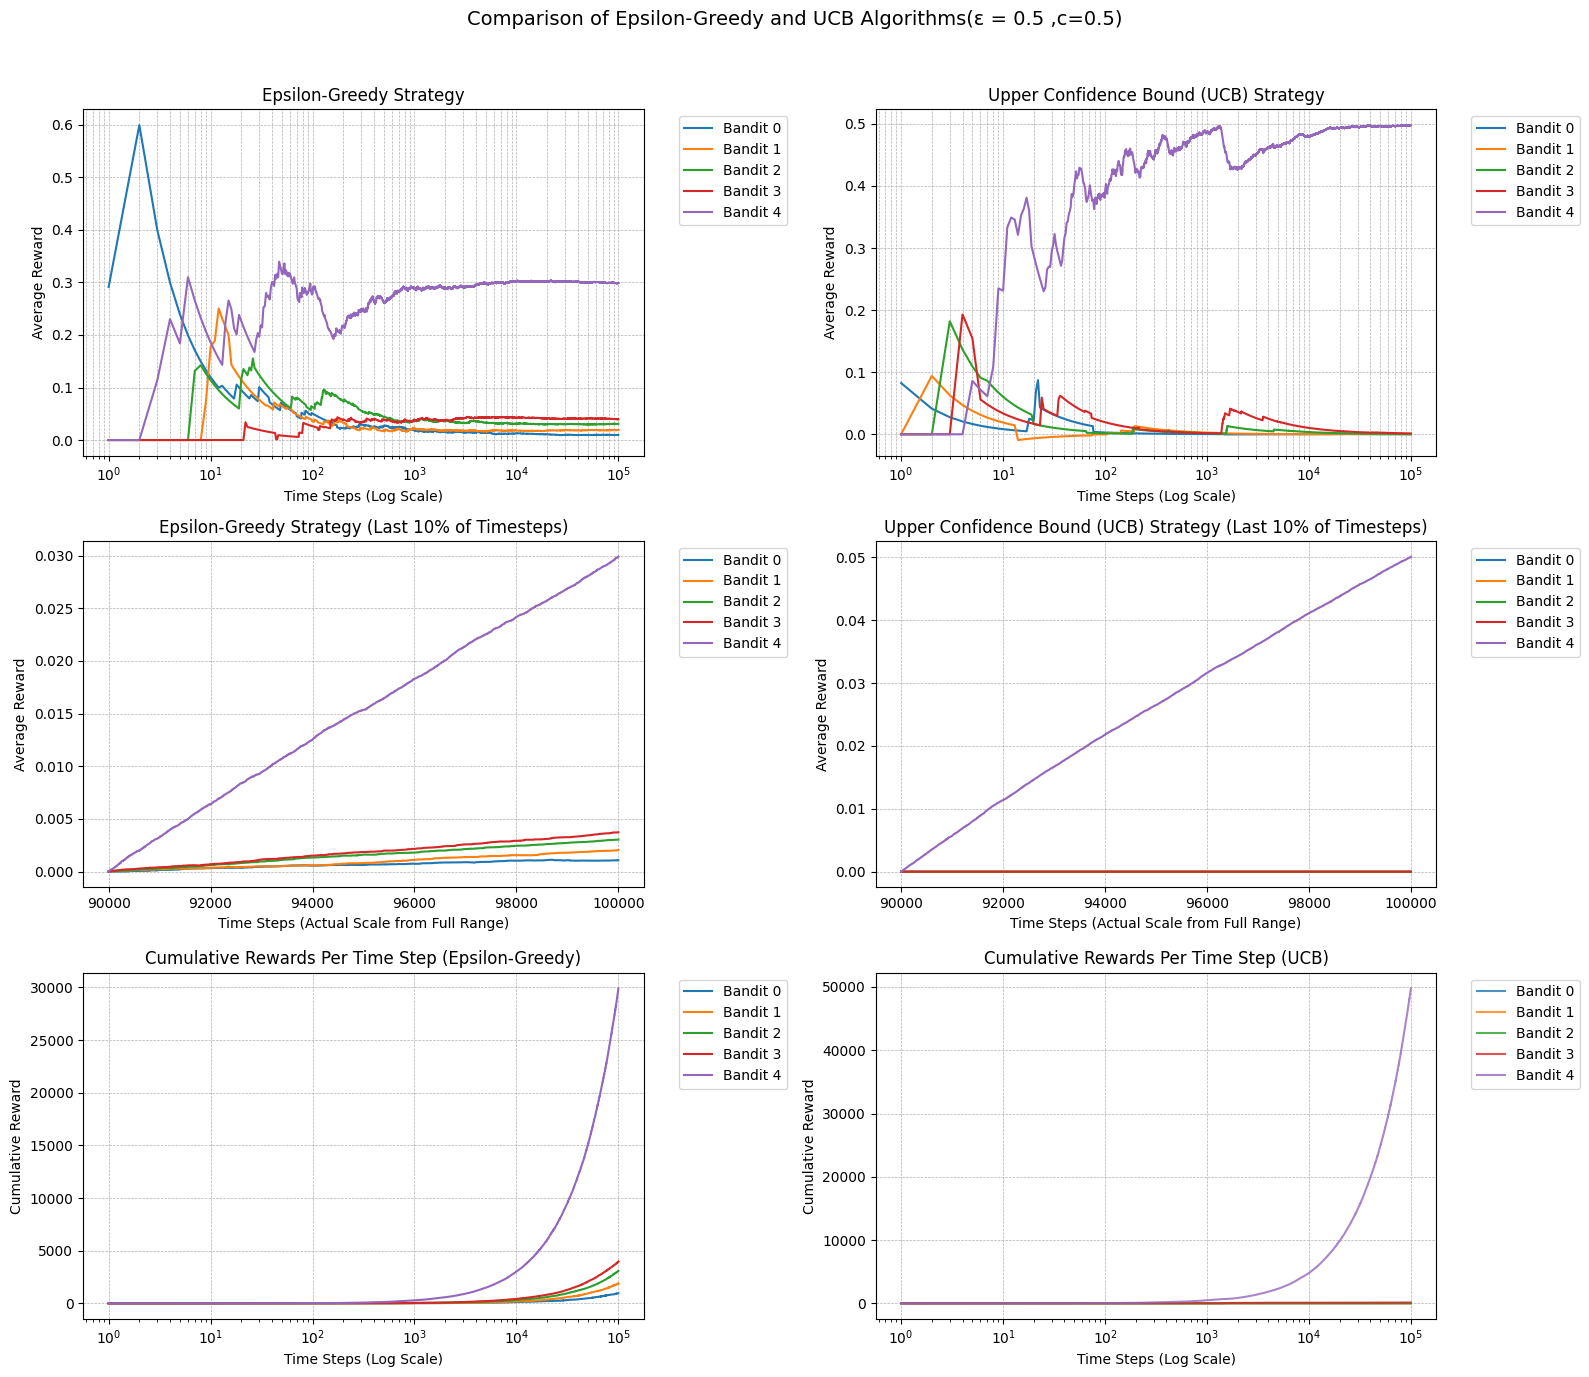

In [9]:
rew_epsilon_3, rew_ucb_3  = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=0.5, ucb_c=0.5)

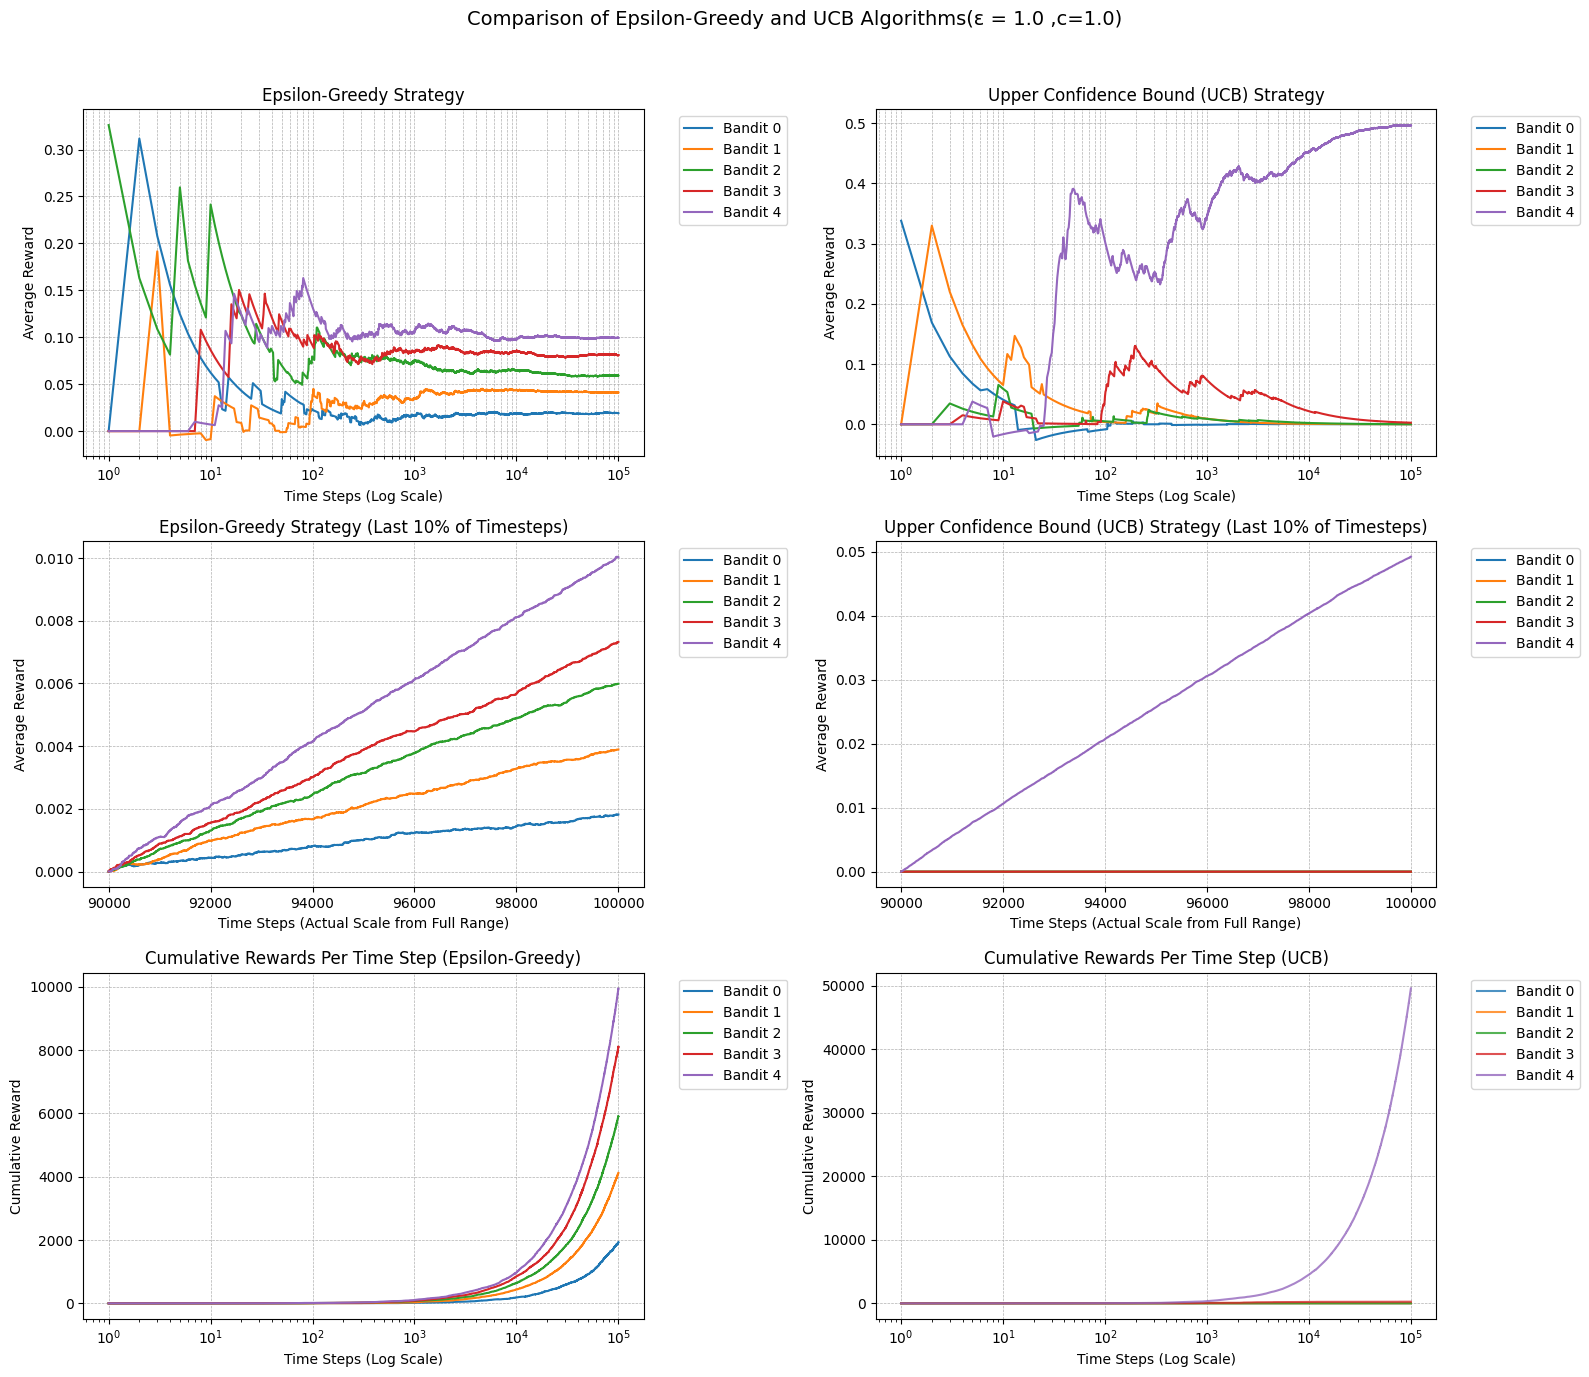

In [10]:
rew_epsilon_4, rew_ucb_4  = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=1.0, ucb_c=1.0)

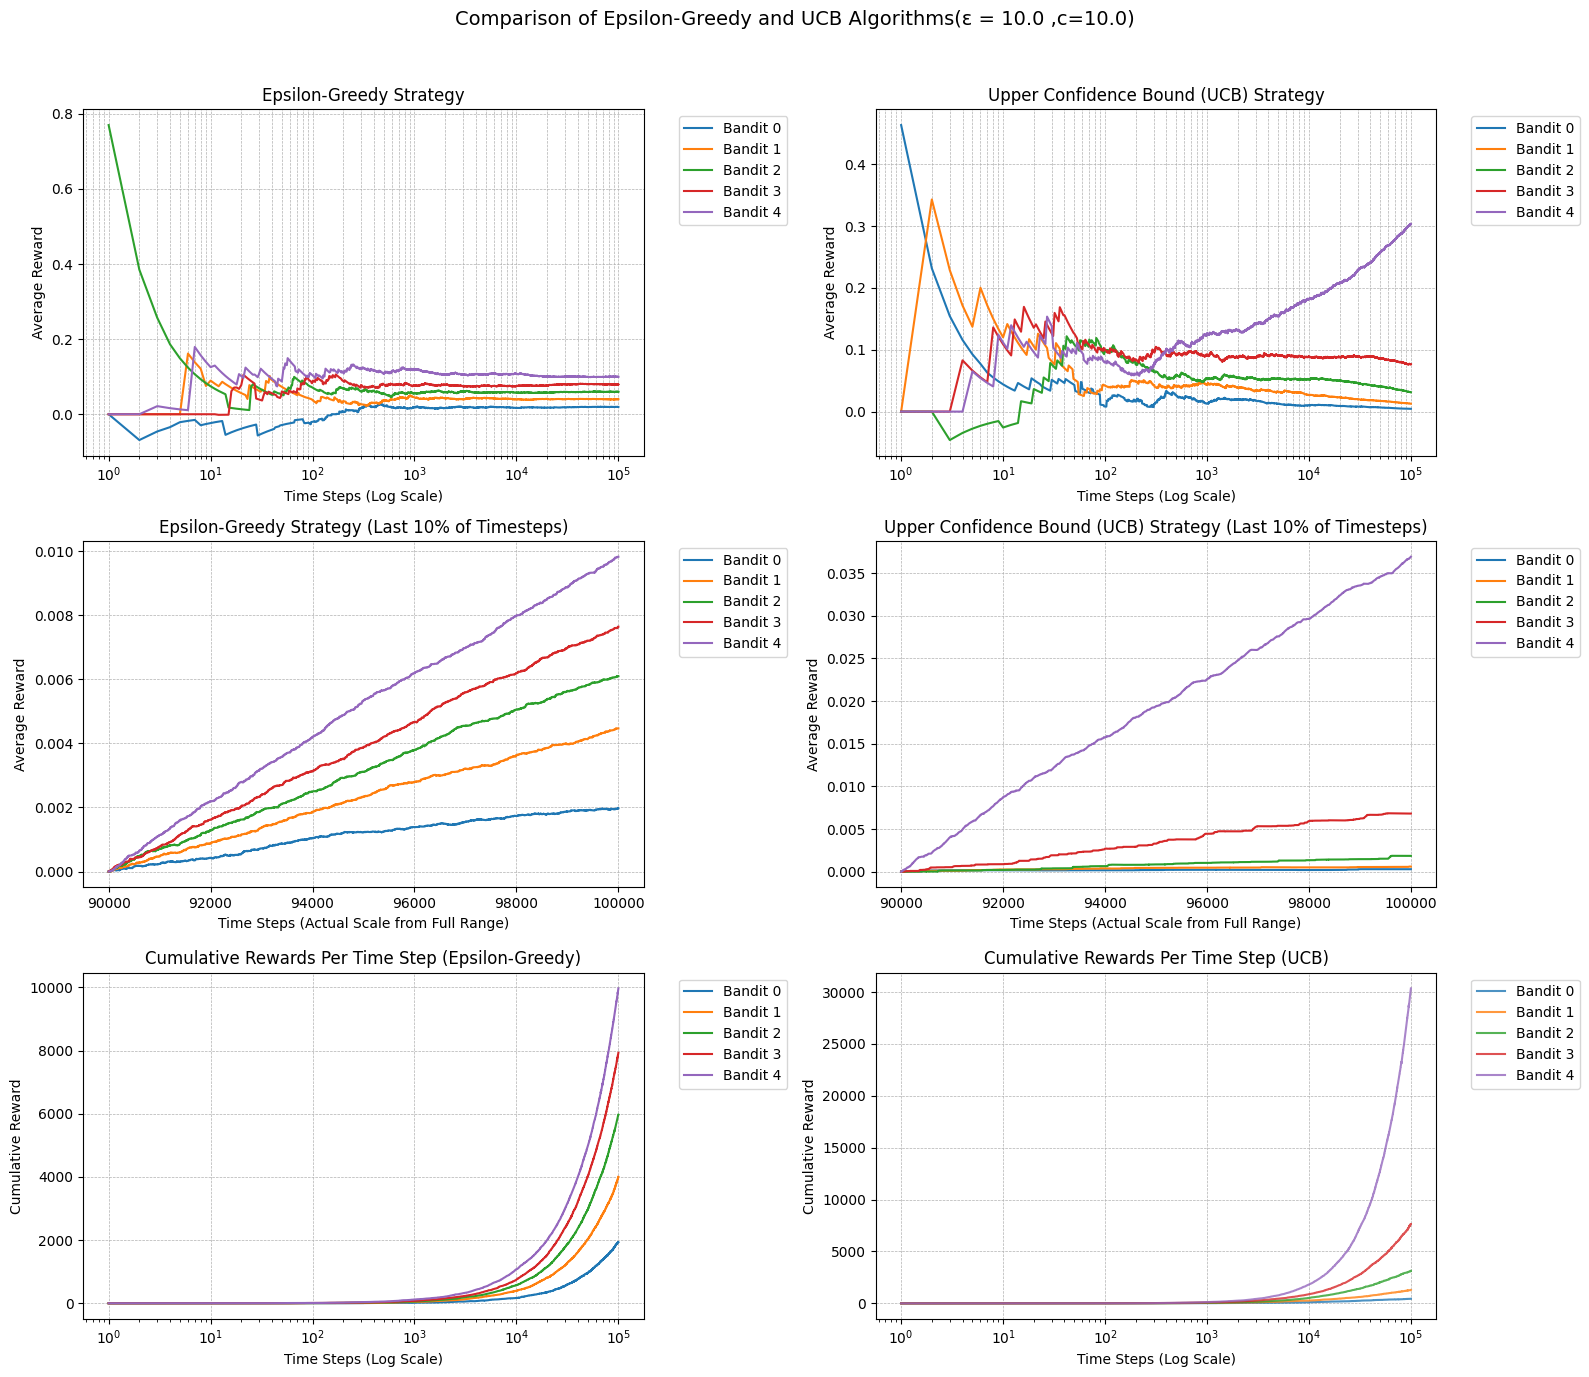

In [11]:
rew_epsilon_5, rew_ucb_5  = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=10.0, ucb_c=10.0)

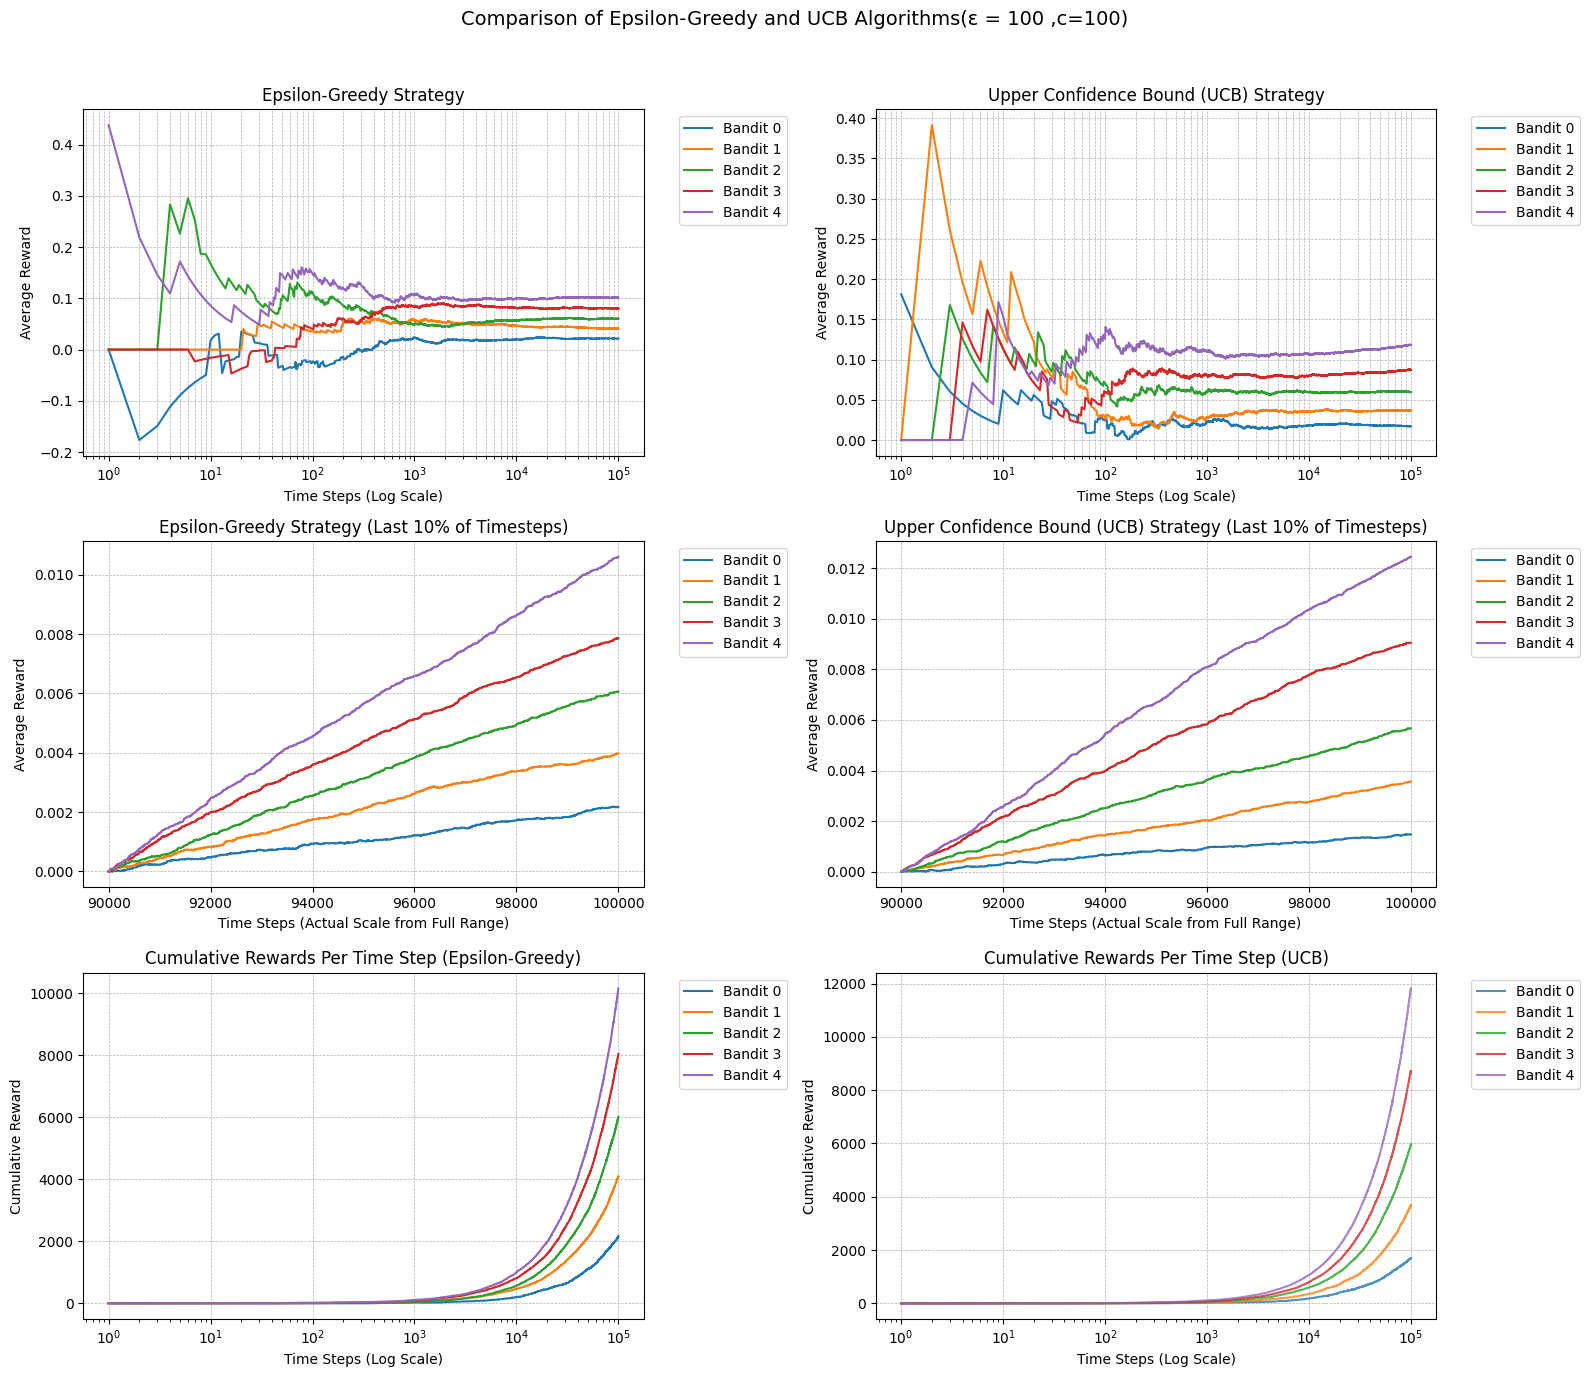

In [12]:
rew_epsilon_6, rew_ucb_6  = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=100, ucb_c=100)

In [15]:
def plot_cumsum_per_config(rew_epsilon_list, rew_ucb_list, time_steps):    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  
    time_full = np.arange(time_steps) + 1  

    # --- Compute Cumulative Sum for Each Epsilon-Greedy Configuration ---
    for i, rewards in enumerate(rew_epsilon_list):
        actions = np.argmax(rewards, axis=0) 
        cumsum_action = np.cumsum(actions) / time_full 

        axes[0].plot(time_full, cumsum_action, label=f"Epsilon-Greedy Run {i+1}")

    axes[0].set_xscale("log") 
    axes[0].set_title("Cumulative Avg Selected Bandit Over Time (Epsilon-Greedy)")
    axes[0].set_xlabel("Time Steps (Log Scale)")
    axes[0].set_ylabel("Cumulative Avg Selected Bandit")
    axes[0].legend()
    axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

    # --- Compute Cumulative Sum for Each UCB Configuration ---
    for i, rewards in enumerate(rew_ucb_list):
        actions = np.argmax(rewards, axis=0)  
        cumsum_action = np.cumsum(actions) / time_full 

        axes[1].plot(time_full, cumsum_action, label=f"UCB Run {i+1}")

    axes[1].set_xscale("log")
    axes[1].set_title("Cumulative Avg Selected Bandit Over Time (UCB)")
    axes[1].set_xlabel("Time Steps (Log Scale)")
    axes[1].set_ylabel("Cumulative Avg Selected Bandit")
    axes[1].legend()
    axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.suptitle("Comparison of Cumulative Avg Selected Bandit Over Time (Epsilon-Greedy vs. UCB)")
    plt.tight_layout()
    plt.show()

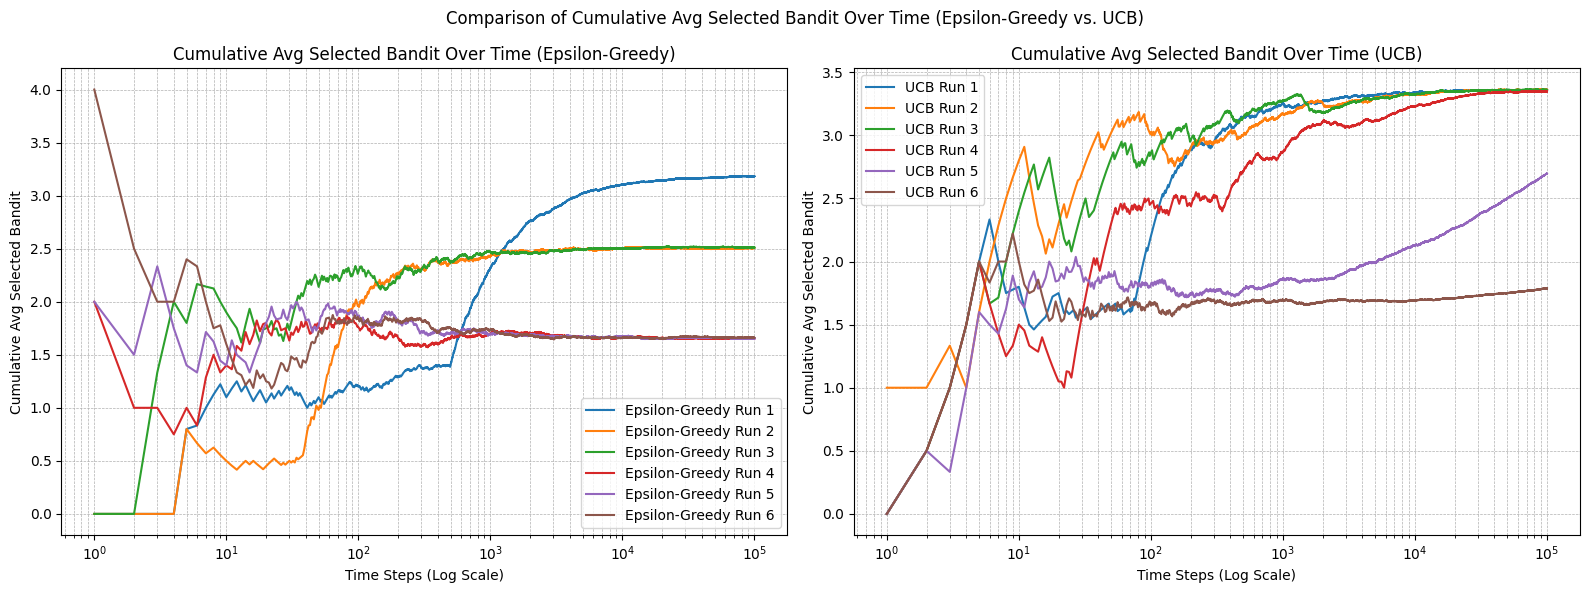

In [16]:
plot_cumsum_per_config(
    rew_epsilon_list=[rew_epsilon_1, rew_epsilon_2, rew_epsilon_3, rew_epsilon_4, rew_epsilon_5, rew_epsilon_6],  
    rew_ucb_list=[rew_ucb_1, rew_ucb_2, rew_ucb_3, rew_ucb_4, rew_ucb_5, rew_ucb_6],
    time_steps=time_step
    )